In [116]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from xgboost import XGBClassifier
from functools import partial
from skopt import gp_minimize
from skopt import space
from skopt.plots import plot_convergence

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [117]:
gcr_data = pd.read_csv("german_credit_data.csv", index_col=0)

In [118]:
gcr_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [119]:
gcr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [120]:
gcr_data_lb = gcr_data.copy()

In [121]:
gcr_data_lb['Purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64

In [122]:
gcr_data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [123]:
housing_map = {'free': 1, 'rent': 2, 'own': 3}

savAcc_map = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}

checkAcc_map = {'little': 1, 'moderate': 2, 'rich': 3}

gender_map = {'female': 0,'male': 1}

risk_map = {'good': 0, 'bad': 1}

lb_en = LabelEncoder()

gcr_data.loc[:,'Purpose'] = lb_en.fit_transform(gcr_data.loc[:,'Purpose']) 

gcr_data.loc[:,'Housing'] = gcr_data['Housing'].map(housing_map)
gcr_data.loc[:,'Saving accounts'] = gcr_data['Saving accounts'].map(savAcc_map)
gcr_data.loc[:,'Checking account'] = gcr_data['Checking account'].map(checkAcc_map)
gcr_data.loc[:,'Sex'] = gcr_data['Sex'].map(gender_map)
gcr_data.loc[:,'Risk'] = gcr_data['Risk'].map(risk_map)

In [124]:
gcr_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,3,NaN,1.0,1169,6,5,0
1,22,0,2,3,1.0,2.0,5951,48,5,1
2,49,1,1,3,1.0,NaN,2096,12,3,0
3,45,1,2,1,1.0,1.0,7882,42,4,0
4,53,1,2,1,1.0,1.0,4870,24,1,1


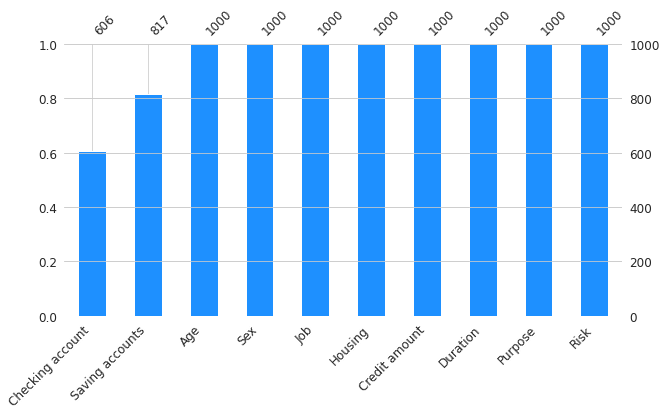

In [125]:
missingno.bar(gcr_data, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [126]:
#Just to check number of null values of every column in data

for col in gcr_data.columns:
    null_val = gcr_data[col].isnull().sum()
    null_prec = (null_val * 100) / gcr_data.shape[0]
    print('> %s , Missing: %d (%.1f%%)' % (col, null_val, null_prec))

> Age , Missing: 0 (0.0%)
> Sex , Missing: 0 (0.0%)
> Job , Missing: 0 (0.0%)
> Housing , Missing: 0 (0.0%)
> Saving accounts , Missing: 183 (18.3%)
> Checking account , Missing: 394 (39.4%)
> Credit amount , Missing: 0 (0.0%)
> Duration , Missing: 0 (0.0%)
> Purpose , Missing: 0 (0.0%)
> Risk , Missing: 0 (0.0%)


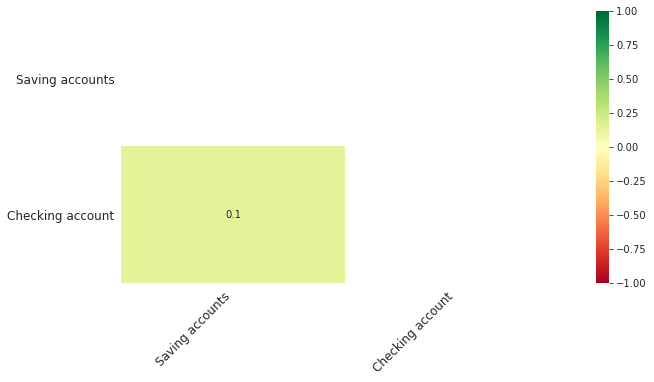

In [127]:
missingno.heatmap(gcr_data, cmap="RdYlGn", figsize=(10,5), fontsize=12);

In [128]:
gcr_data1 = gcr_data.copy()

In [129]:
knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(gcr_data1))
gcr_data1 = pd.DataFrame(X, columns = gcr_data1.columns)

In [130]:
gcr_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   float64
 1   Sex               1000 non-null   float64
 2   Job               1000 non-null   float64
 3   Housing           1000 non-null   float64
 4   Saving accounts   1000 non-null   float64
 5   Checking account  1000 non-null   float64
 6   Credit amount     1000 non-null   float64
 7   Duration          1000 non-null   float64
 8   Purpose           1000 non-null   float64
 9   Risk              1000 non-null   float64
dtypes: float64(10)
memory usage: 78.2 KB


In [131]:
gcr_data1.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67.0,1.0,2.0,3.0,1.0,1.0,1169.0,6.0,5.0,0.0
1,22.0,0.0,2.0,3.0,1.0,2.0,5951.0,48.0,5.0,1.0
2,49.0,1.0,1.0,3.0,1.0,3.0,2096.0,12.0,3.0,0.0
3,45.0,1.0,2.0,1.0,1.0,1.0,7882.0,42.0,4.0,0.0
4,53.0,1.0,2.0,1.0,1.0,1.0,4870.0,24.0,1.0,1.0


In [132]:
X = gcr_data1.drop(['Risk'], axis = 1)
Y = gcr_data1['Risk']

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 1.0
Test AUC Score 0.6514004087029692


<AxesSubplot:xlabel='Risk', ylabel='count'>

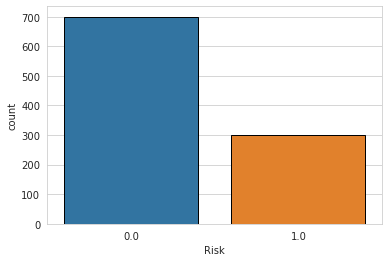

In [134]:
sns.countplot(gcr_data1['Risk'], edgecolor = 'black')

In [135]:
def plot_auc_curve(fpr, tpr, auc):
    plt.figure(figsize = (16,6))
    plt.plot(fpr,tpr,'b+',linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5)
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Postive Rate')
    plt.title(f'ROC Curve Having AUC = {auc}')

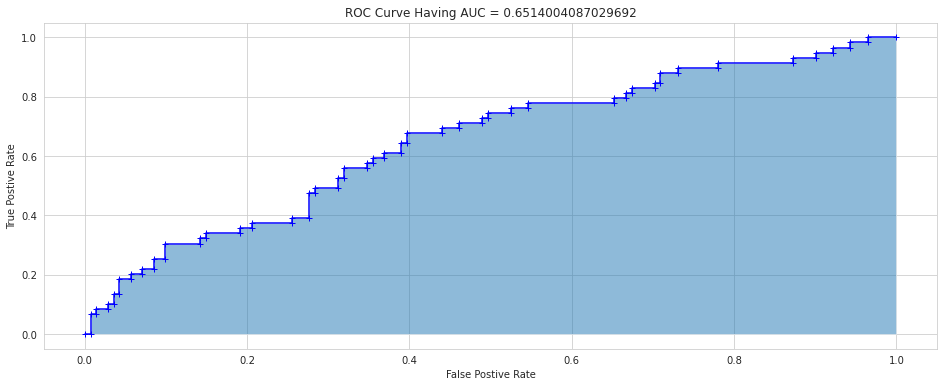

In [136]:
plot_auc_curve(fpr, tpr, auc_test)

In [137]:
# funtion to plot learning curves

def plot_learning_cuve(model, X, Y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(200,len(x_train),200):
        
        model.fit(x_train.iloc[:m,:], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')



    plt.show()
        

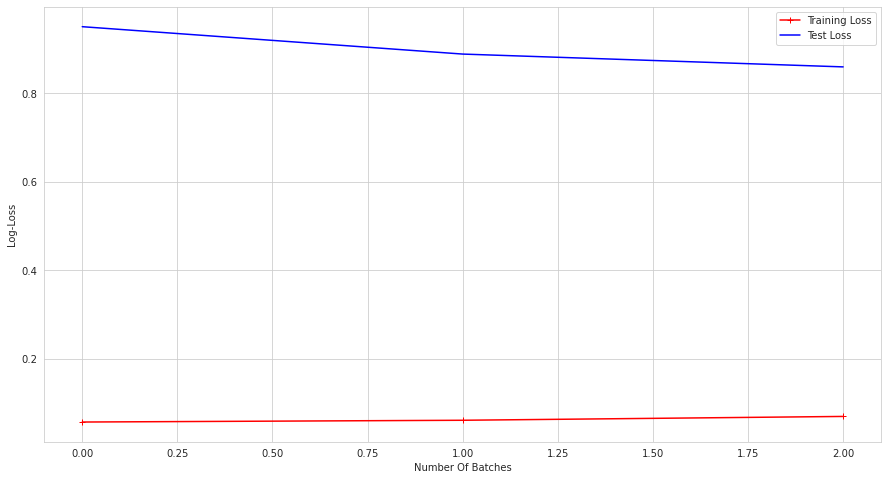

In [138]:
plot_learning_cuve(XGBClassifier(), X, Y)

In [139]:
from imblearn.over_sampling import SMOTE

<AxesSubplot:xlabel='Risk', ylabel='count'>

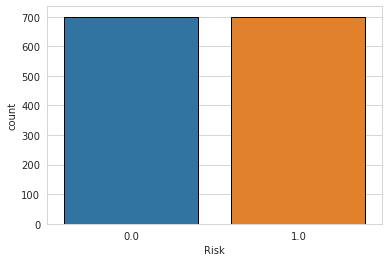

In [140]:
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(X,Y)


sns.countplot(Y_smote, edgecolor = 'black')

In [141]:
print(X_smote.shape)

(1400, 9)


In [142]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.9999968104006456
Test AUC Score 0.8549618320610687


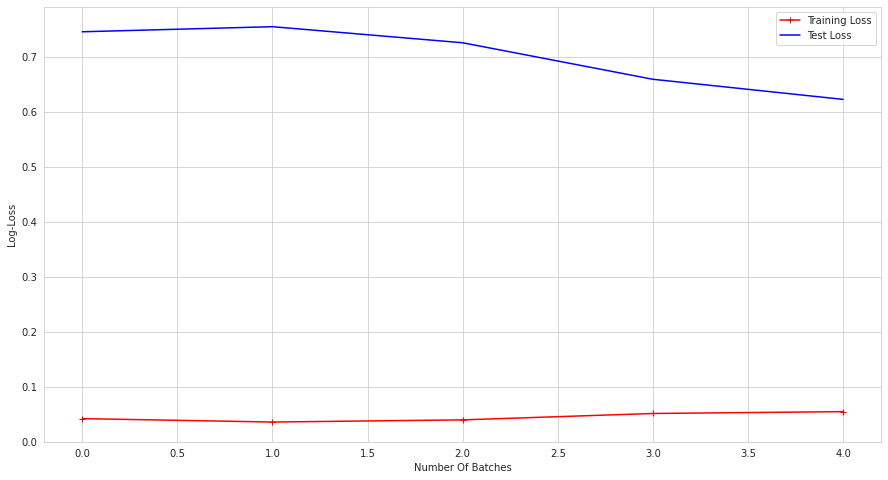

In [143]:
plot_learning_cuve(XGBClassifier(), X_smote, Y_smote)

<AxesSubplot:xlabel='Risk', ylabel='count'>

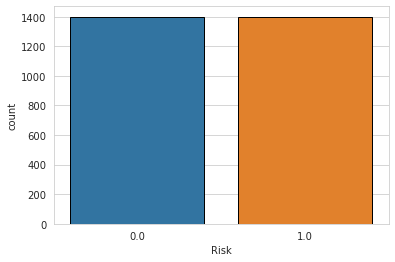

In [144]:
smote = SMOTE(random_state = 446)
X_smote1, Y_smote1 = smote.fit_resample(X,Y)


X_final = pd.concat([X_smote, X_smote1], axis = 0).reset_index(drop = True)
Y_final = pd.concat([Y_smote, Y_smote1], axis = 0).reset_index(drop = True)

sns.countplot(Y_final, edgecolor = 'black')

In [145]:
print(X_final.shape)

(2800, 9)


In [146]:
X_train, X_val, y_train, y_val = train_test_split(X_final, Y_final, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()


clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")


Train AUC Score 0.9999306405939079
Test AUC Score 0.9887025122549019


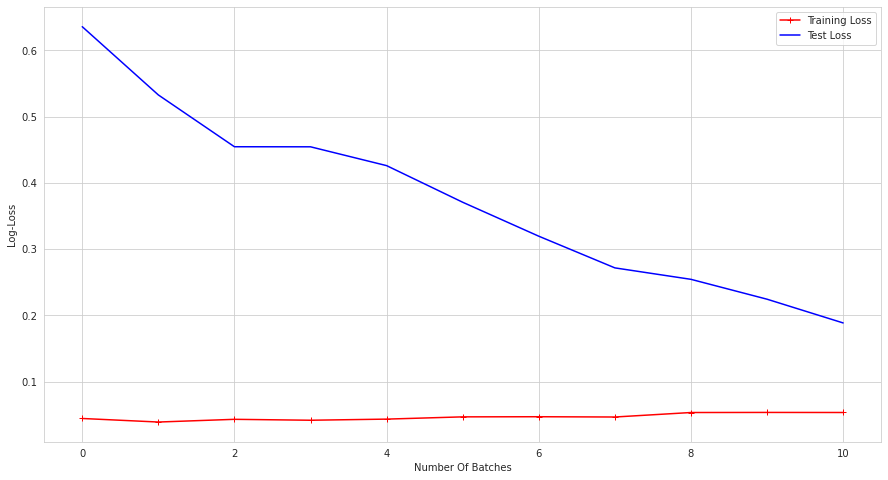

In [147]:
plot_learning_cuve(XGBClassifier(), X_final, Y_final)

In [148]:
def optimize(params, param_names, x, y):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    clf = XGBClassifier(tree_method = 'hist', **params)
    
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]

    
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)
    
    

In [149]:
#define a parameter space

param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Real(0.01,100, name = 'min_child_weight'),
                space.Real(0.01,1000, name = 'gamma'),
                space.Real(0.1, 1, prior = 'uniform', name = 'colsample_bytree'),
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators' ,'min_child_weight', 'gamma', 'colsample_bytree']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X_smote, y = Y_smote)

In [150]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 30, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 1225, 'min_child_weight': 93.37810441628334, 'gamma': 149.14915946808011, 'colsample_bytree': 0.4799350368077946}
AUC score of test 0 f 0.5
Current parameters of fold number 1 -> {'n_estimators': 1225, 'min_child_weight': 93.37810441628334, 'gamma': 149.14915946808011, 'colsample_bytree': 0.4799350368077946}
AUC score of test 1 f 0.5
Current parameters of fold number 2 -> {'n_estimators': 1225, 'min_child_weight': 93.37810441628334, 'gamma': 149.14915946808011, 'colsample_bytree': 0.4799350368077946}
AUC score of test 2 f 0.5
Current parameters of fold number 3 -> {'n_estimators': 1225, 'min_child_weight': 93.37810441628334, 'gamma': 149.14915946808011, 'colsample_bytree': 0.4799350368077946}
AUC score of test 3 f 0.5
Current parameters of fold number 4 -> {'n_estimators': 1225, 'min_child_weight': 93.37810441628334, 'gamma': 149.14915946808011, 'colsample_bytree': 0.47

In [151]:
best_params = dict(zip(param_names, result.x))
print(f'Best Parameters : {best_params}')
print(f'Best AUC score : {result.fun}')

Best Parameters : {'n_estimators': 100, 'min_child_weight': 0.01, 'gamma': 4.327197509790755, 'colsample_bytree': 1.0}
Best AUC score : -0.8608163265306121


In [152]:
# splitting train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 2020)

# initialize model with best parameters
clf = XGBClassifier(**best_params)

# fit model
clf.fit(X_train, y_train)

# predicting probabilities of training data
y_train_pred = clf.predict_proba(X_train)


y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 0.9464508928571429
Test AUC Score 0.8453571428571429


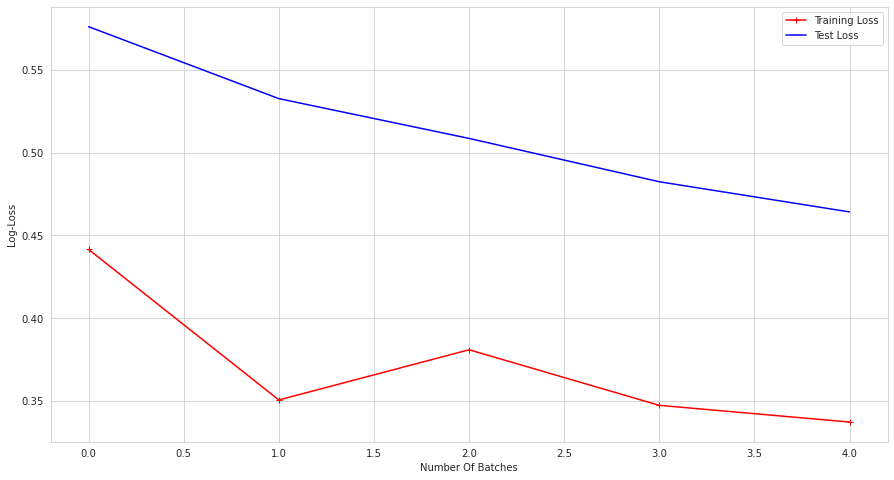

In [153]:
plot_learning_cuve(XGBClassifier(**best_params),X_smote,Y_smote)

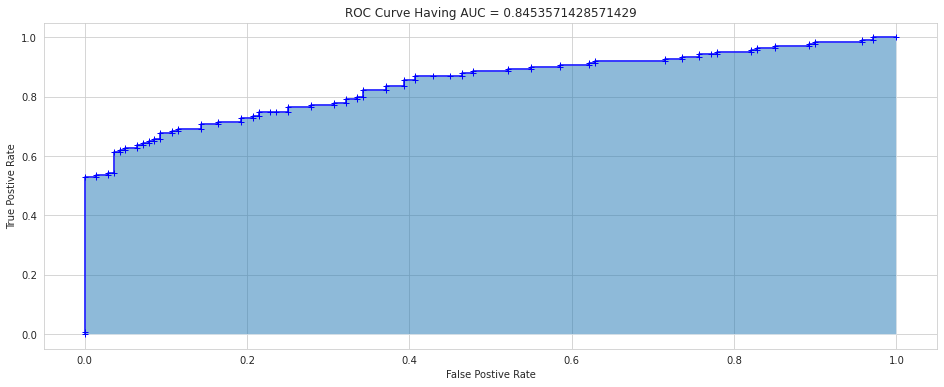

In [154]:
plot_auc_curve(fpr, tpr, auc_test)